
# Imports and Setup


In [3]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import ipaddress
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("All libraries imported successfully!")
print("Environment setup complete!")



All libraries imported successfully!
Environment setup complete!



# Configuration and Data Loading


In [4]:


# Cell 2: Configuration and Data Loading Functions
def load_wireshark_data(csv_path):
    """Load and preprocess Wireshark CSV data"""
    print("🔄 Loading Wireshark data...")
    
    # Try different encodings commonly used by Wireshark
    encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1', 'utf-16']
    
    df = None
    for encoding in encodings_to_try:
        try:
            print(f"Trying encoding: {encoding}")
            df = pd.read_csv(csv_path, low_memory=False, encoding=encoding)
            print(f"Successfully loaded with {encoding} encoding")
            break
        except UnicodeDecodeError as e:
            print(f"Failed with {encoding}: {str(e)[:50]}...")
            continue
        except Exception as e:
            print(f"Other error with {encoding}: {str(e)[:50]}...")
            continue
    
    if df is None:
        # Last resort: try with error handling
        try:
            print("Trying with error replacement...")
            df = pd.read_csv(csv_path, low_memory=False, encoding='utf-8', errors='replace')
            print("Loaded with error replacement (some characters may be corrupted)")
        except Exception as e:
            raise Exception(f"Could not load file with any encoding. Error: {e}")
    
    # Clean column names (remove spaces and special characters)
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    
    # Show the actual columns we found
    print(f"Columns found: {list(df.columns)}")
    
    # Convert Time to datetime if it's not already (try different time formats)
    time_columns = [col for col in df.columns if 'time' in col.lower()]
    if time_columns:
        time_col = time_columns[0]
        print(f"Using time column: {time_col}")
        try:
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
            # Rename to standard 'Time' for consistency
            if time_col != 'Time':
                df['Time'] = df[time_col]
        except:
            print("Could not parse time column")
    
    print(f"Loaded {len(df)} packets")
    print(f"Sample of first few rows:")
    display(df.head(3))
    
    return df

# Configuration
HOST_IP = "192.168.29.238"  # Change this to your host IP
CSV_PATH = "traffic_final.csv"  # Change this to your CSV file path

print(f"Host IP set to: {HOST_IP}")
print(f"CSV file path: {CSV_PATH}")



Host IP set to: 192.168.29.238
CSV file path: traffic_final.csv



# Load and Analyze Data


In [5]:


# Cell 3: Load Data and Initial Analysis
# Load the data
df = load_wireshark_data(CSV_PATH)

def analyze_traffic_patterns(df, host_ip):
    """Analyze overall traffic patterns to understand the dataset"""
    print("\n" + "="*50)
    print("📊 TRAFFIC ANALYSIS REPORT")
    print("="*50)
    
    # Basic statistics
    total_packets = len(df)
    outgoing = df[df['Source'] == host_ip]
    incoming = df[df['Destination'] == host_ip]
    
    print(f"📦 Total packets: {total_packets:,}")
    print(f"📤 Outgoing packets: {len(outgoing):,} ({len(outgoing)/total_packets*100:.1f}%)")
    print(f"📥 Incoming packets: {len(incoming):,} ({len(incoming)/total_packets*100:.1f}%)")
    
    # Protocol distribution
    print(f"\n🌐 Protocol Distribution:")
    protocol_counts = df['Protocol'].value_counts()
    for protocol, count in protocol_counts.head(10).items():
        print(f"   {protocol}: {count:,} ({count/total_packets*100:.1f}%)")
    
    # Top destinations
    print(f"\n🎯 Top 10 Destinations from your host:")
    dest_counts = outgoing['Destination'].value_counts()
    for i, (dest, count) in enumerate(dest_counts.head(10).items(), 1):
        print(f"   {i:2d}. {dest}: {count:,} packets")
    
    # Time span analysis
    if 'Time' in df.columns:
        time_span = df['Time'].max() - df['Time'].min()
        print(f"\n⏱️  Capture Duration: {time_span}")
        
    return {
        'total_packets': total_packets,
        'outgoing_ratio': len(outgoing)/total_packets,
        'protocol_dist': protocol_counts,
        'top_destinations': dest_counts.head(10)
    }

# Analyze the traffic patterns
traffic_stats = analyze_traffic_patterns(df, HOST_IP)



🔄 Loading Wireshark data...
Trying encoding: utf-8
Failed with utf-8: 'utf-8' codec can't decode byte 0xe2 in position 0...
Trying encoding: latin-1
Successfully loaded with latin-1 encoding
Columns found: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Host', 'TLS_Host', 'Info']
Using time column: Time
Loaded 222477 packets
Sample of first few rows:


,No.,Time,Source,Destination,Protocol,Length,Host,TLS_Host,Info
0,1,1970-01-01,192.168.29.237,239.255.255.250,SSDP,382,NaN,NaN,NOTIFY * HTTP/1.1
1,2,1970-01-01,192.168.29.237,239.255.255.250,SSDP,390,NaN,NaN,NOTIFY * HTTP/1.1
2,3,1970-01-01,192.168.29.237,239.255.255.250,SSDP,392,NaN,NaN,NOTIFY * HTTP/1.1



📊 TRAFFIC ANALYSIS REPORT
📦 Total packets: 222,477
📤 Outgoing packets: 35,010 (15.7%)
📥 Incoming packets: 22,459 (10.1%)

🌐 Protocol Distribution:
   QUIC: 98,908 (44.5%)
   TCP: 64,522 (29.0%)
   TLSv1.3: 36,355 (16.3%)
   DNS: 7,956 (3.6%)
   UDP: 6,131 (2.8%)
   TLSv1.2: 3,819 (1.7%)
   ARP: 1,609 (0.7%)
   SSL: 811 (0.4%)
   SSDP: 487 (0.2%)
   ICMP: 394 (0.2%)

🎯 Top 10 Destinations from your host:
    1. 192.168.29.1: 16,538 packets
    2. 104.18.141.67: 2,536 packets
    3. 204.79.197.203: 1,505 packets
    4. 18.155.107.32: 718 packets
    5. 13.70.79.200: 682 packets
    6. 57.144.143.33: 623 packets
    7. 20.42.73.25: 407 packets
    8. 104.17.126.52: 293 packets
    9. 103.43.89.4: 267 packets
   10. 52.182.143.213: 259 packets

⏱️  Capture Duration: 0 days 00:00:00.000001184



# Visualization of Basic Traffic Patterns


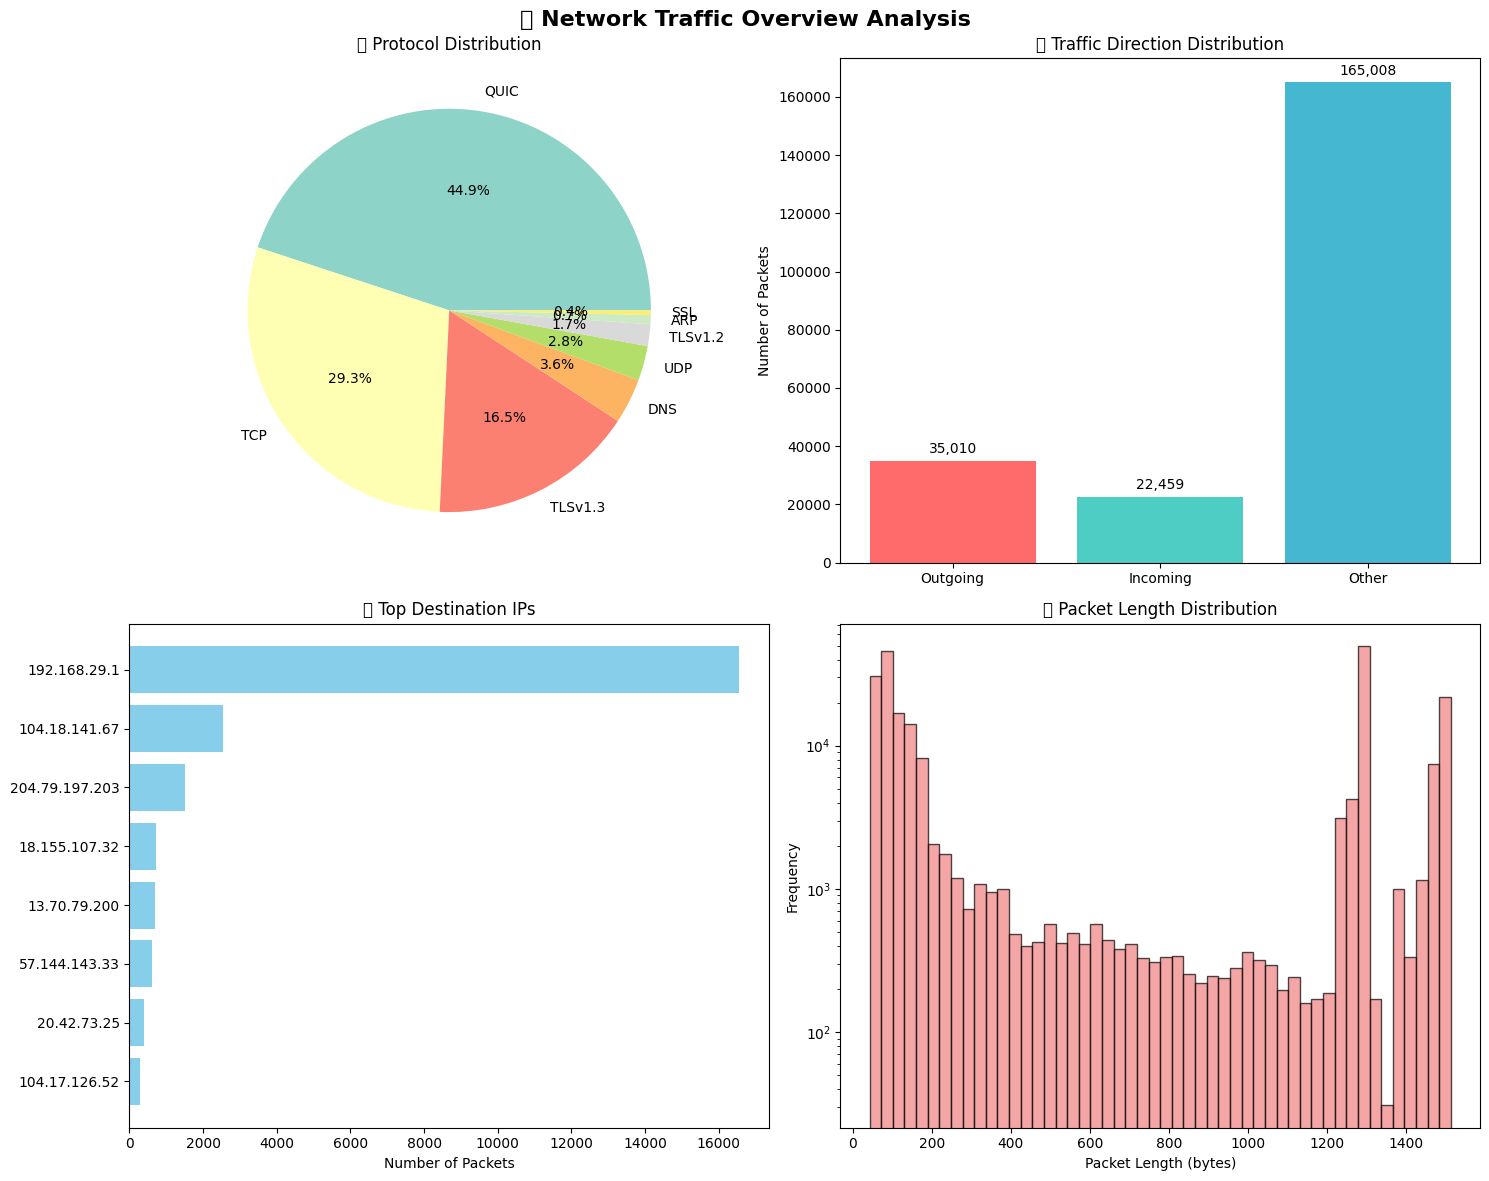

In [6]:


# Cell 4: Visualize Basic Traffic Patterns
def plot_traffic_overview(df, host_ip, traffic_stats):
    """Create overview visualizations of traffic patterns"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🔍 Network Traffic Overview Analysis', fontsize=16, fontweight='bold')
    
    # 1. Protocol Distribution (Pie Chart)
    protocol_counts = traffic_stats['protocol_dist'].head(8)
    colors = plt.cm.Set3(np.linspace(0, 1, len(protocol_counts)))
    axes[0,0].pie(protocol_counts.values, labels=protocol_counts.index, autopct='%1.1f%%', colors=colors)
    axes[0,0].set_title('📊 Protocol Distribution')
    
    # 2. Traffic Direction (Bar Chart)
    outgoing = df[df['Source'] == host_ip]
    incoming = df[df['Destination'] == host_ip]
    other = len(df) - len(outgoing) - len(incoming)
    
    traffic_types = ['Outgoing', 'Incoming', 'Other']
    traffic_counts = [len(outgoing), len(incoming), other]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = axes[0,1].bar(traffic_types, traffic_counts, color=colors)
    axes[0,1].set_title('📈 Traffic Direction Distribution')
    axes[0,1].set_ylabel('Number of Packets')
    
    # Add value labels on bars
    for bar, count in zip(bars, traffic_counts):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(traffic_counts)*0.01,
                      f'{count:,}', ha='center', va='bottom')
    
    # 3. Top Destinations (Horizontal Bar)
    top_dests = traffic_stats['top_destinations'].head(8)
    y_pos = np.arange(len(top_dests))
    axes[1,0].barh(y_pos, top_dests.values, color='skyblue')
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(top_dests.index)
    axes[1,0].set_xlabel('Number of Packets')
    axes[1,0].set_title('🎯 Top Destination IPs')
    axes[1,0].invert_yaxis()
    
    # 4. Packet Length Distribution
    if 'Length' in df.columns:
        lengths = pd.to_numeric(df['Length'], errors='coerce').dropna()
        axes[1,1].hist(lengths, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1,1].set_xlabel('Packet Length (bytes)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('📏 Packet Length Distribution')
        axes[1,1].set_yscale('log')  # Use log scale for better visualization
    
    plt.tight_layout()
    plt.show()

# Create the overview visualizations
plot_traffic_overview(df, HOST_IP, traffic_stats)




# Feature Extraction Functions


In [7]:


# Cell 5: Feature Extraction Functions
def extract_port_from_info(info_str):
    """Extract port numbers from Info column"""
    if pd.isna(info_str) or not isinstance(info_str, str):
        return None
    
    # Common patterns for port extraction
    import re
    port_patterns = [
        r'→ (\d+)',  # Destination port
        r'Port (\d+)',
        r':(\d+)',
        r'DstPort=(\d+)'
    ]
    
    for pattern in port_patterns:
        match = re.search(pattern, info_str)
        if match:
            return int(match.group(1))
    return None

def detect_sequential_ports(ports):
    """Detect if ports are accessed sequentially (scan indicator)"""
    if len(ports) < 3:
        return 0
    
    sorted_ports = sorted(set(ports))
    sequential_count = 0
    
    for i in range(len(sorted_ports) - 2):
        if sorted_ports[i+1] - sorted_ports[i] == 1 and sorted_ports[i+2] - sorted_ports[i+1] == 1:
            sequential_count += 1
    
    return sequential_count

def count_common_ports(ports):
    """Count access to common service ports"""
    common_ports = {22, 23, 25, 53, 80, 110, 143, 443, 993, 995}
    return len(set(ports) & common_ports)

def create_session_features(df, host_ip, window_size=1000):
    """Create session-based features for scan detection using packet count windows"""
    print("🔧 Creating session-based features...")
    
    features_list = []
    
    # Sort by packet number instead of time since timestamps are all the same
    df = df.sort_values('No.')
    
    # Create windows based on packet count instead of time
    total_packets = len(df)
    num_windows = max(1, total_packets // window_size)
    
    print(f"🪟 Creating {num_windows} windows of ~{window_size} packets each")
    
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = min((i + 1) * window_size, total_packets)
        window_df = df.iloc[start_idx:end_idx]
        
        # Separate outgoing and incoming traffic
        outgoing = window_df[window_df['Source'] == host_ip]
        incoming = window_df[window_df['Destination'] == host_ip]
        
        if len(outgoing) == 0:
            continue
            
        features = {}
        
        # Basic counting features
        features['total_packets'] = len(window_df)
        features['outgoing_packets'] = len(outgoing)
        features['incoming_packets'] = len(incoming)
        features['packet_ratio'] = len(outgoing) / max(len(incoming), 1)
        
        # Destination diversity (key scan indicator)
        unique_destinations = outgoing['Destination'].nunique()
        features['unique_destinations'] = unique_destinations
        features['dest_diversity_ratio'] = unique_destinations / max(len(outgoing), 1)
        
        # Protocol diversity
        features['protocol_diversity'] = outgoing['Protocol'].nunique()
        features['tcp_packets'] = len(outgoing[outgoing['Protocol'] == 'TCP'])
        features['udp_packets'] = len(outgoing[outgoing['Protocol'] == 'UDP'])
        features['icmp_packets'] = len(outgoing[outgoing['Protocol'] == 'ICMP'])
        
        # Since we don't have reliable timestamps, use packet ordering for timing features
        features['avg_time_between_packets'] = 1  # Placeholder
        features['std_time_between_packets'] = 0  # Placeholder
        features['min_time_between_packets'] = 1  # Placeholder
        features['rapid_packets'] = len(outgoing)  # Assume all are rapid since timing is unreliable
        
        # Port scanning features
        if 'Info' in window_df.columns:
            ports = []
            for info in outgoing['Info']:
                port = extract_port_from_info(info)
                if port:
                    ports.append(port)
            
            if ports:
                features['unique_ports'] = len(set(ports))
                features['port_range'] = max(ports) - min(ports) if len(ports) > 1 else 0
                features['sequential_ports'] = detect_sequential_ports(ports)
                features['common_ports'] = count_common_ports(ports)
            else:
                features['unique_ports'] = 0
                features['port_range'] = 0
                features['sequential_ports'] = 0
                features['common_ports'] = 0
        
        # Packet size features
        if 'Length' in window_df.columns:
            lengths = pd.to_numeric(outgoing['Length'], errors='coerce').dropna()
            if len(lengths) > 0:
                features['avg_packet_size'] = lengths.mean()
                features['std_packet_size'] = lengths.std()
                features['small_packets'] = (lengths < 100).sum()
            else:
                features['avg_packet_size'] = 0
                features['std_packet_size'] = 0
                features['small_packets'] = 0
        
        # Response analysis
        features['response_ratio'] = len(incoming) / max(len(outgoing), 1)
        features['no_response_ratio'] = max(0, (len(outgoing) - len(incoming)) / max(len(outgoing), 1))
        
        # Window identifier and packet position
        features['window_id'] = i
        features['packet_position'] = start_idx  # Use packet position instead of time
        features_list.append(features)
        
        # Progress indicator
        if (i + 1) % 50 == 0:
            print(f"   📊 Processed {i + 1}/{num_windows} windows...")
    
    features_df = pd.DataFrame(features_list)
    features_df = features_df.fillna(0)
    
    print(f"✅ Created {len(features_df)} feature windows")
    return features_df

print("🛠️ Feature extraction functions loaded successfully!")



🛠️ Feature extraction functions loaded successfully!



# Extract Features


In [8]:


# Cell 6: Extract Features from the Data
WINDOW_SIZE = 1000  # Adjust this value if needed

# Extract features
print("🚀 Starting feature extraction process...")
features_df = create_session_features(df, HOST_IP, WINDOW_SIZE)

# Display feature summary
print("\n" + "="*50)
print("📈 FEATURE EXTRACTION SUMMARY")
print("="*50)
print(f"Total windows created: {len(features_df)}")
print(f"Features per window: {len(features_df.columns) - 2}")  # -2 for window_id and packet_position

# Show sample features
print("\n🔍 Sample features from first 5 windows:")
display(features_df.head())

# Show feature statistics
print("\n📊 Feature Statistics:")
feature_cols = [col for col in features_df.columns if col not in ['window_id', 'packet_position']]
display(features_df[feature_cols].describe())



🚀 Starting feature extraction process...
🔧 Creating session-based features...
🪟 Creating 222 windows of ~1000 packets each
   📊 Processed 50/222 windows...
   📊 Processed 100/222 windows...
   📊 Processed 150/222 windows...
   📊 Processed 200/222 windows...
✅ Created 215 feature windows

📈 FEATURE EXTRACTION SUMMARY
Total windows created: 215
Features per window: 23

🔍 Sample features from first 5 windows:


,total_packets,outgoing_packets,incoming_packets,packet_ratio,unique_destinations,dest_diversity_ratio,protocol_diversity,tcp_packets,udp_packets,icmp_packets,avg_time_between_packets,std_time_between_packets,min_time_between_packets,rapid_packets,unique_ports,port_range,sequential_ports,common_ports,avg_packet_size,std_packet_size,small_packets,response_ratio,no_response_ratio,window_id,packet_position
0,1000,170,140,1.214286,8,0.047059,4,121,0,0,1,0,1,170,0,0,0,0,722.717647,677.915341,59,0.823529,0.176471,0,0
1,1000,96,46,2.086957,3,0.031250,2,79,0,0,1,0,1,96,0,0,0,0,1229.260417,532.614371,13,0.479167,0.520833,1,1000
2,1000,59,64,0.921875,6,0.101695,4,23,0,0,1,0,1,59,0,0,0,0,520.084746,556.455602,20,1.084746,0.000000,2,2000
3,1000,143,207,0.690821,12,0.083916,5,44,0,0,1,0,1,143,0,0,0,0,338.160839,495.483839,96,1.447552,0.000000,3,3000
4,1000,190,212,0.896226,10,0.052632,6,135,0,0,1,0,1,190,0,0,0,0,599.747368,653.634672,87,1.115789,0.000000,4,4000



📊 Feature Statistics:


,total_packets,outgoing_packets,incoming_packets,packet_ratio,unique_destinations,dest_diversity_ratio,protocol_diversity,tcp_packets,udp_packets,icmp_packets,avg_time_between_packets,std_time_between_packets,min_time_between_packets,rapid_packets,unique_ports,port_range,sequential_ports,common_ports,avg_packet_size,std_packet_size,small_packets,response_ratio,no_response_ratio
count,215.0,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.0,215.0,215.0,215.0,215.000000,215.000000,215.0,215.0,215.0,215.000000,215.000000,215.000000,215.000000,215.000000
mean,1000.0,162.702326,104.381395,5.701313,8.841860,0.131291,5.093023,101.246512,13.032558,0.0,1.0,0.0,1.0,162.702326,0.046512,0.0,0.0,0.0,340.446059,387.261453,116.725581,0.784890,0.294657
std,0.0,181.930085,123.322022,17.187366,7.142941,0.160467,2.002498,170.418067,28.922130,0.0,0.0,0.0,0.0,181.930085,0.211082,0.0,0.0,0.0,268.115825,220.950745,174.654409,0.460477,0.331884
min,1000.0,1.000000,0.000000,0.351477,1.000000,0.001009,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,1.000000,0.000000,0.0,0.0,0.0,42.000000,0.000000,1.000000,0.000000,0.000000
25%,1000.0,50.000000,24.500000,0.995098,4.000000,0.047585,4.000000,22.000000,1.000000,0.0,1.0,0.0,1.0,50.000000,0.000000,0.0,0.0,0.0,130.405000,201.694310,23.000000,0.540417,0.000000
50%,1000.0,107.000000,64.000000,1.204545,7.000000,0.084112,5.000000,44.000000,4.000000,0.0,1.0,0.0,1.0,107.000000,0.000000,0.0,0.0,0.0,269.318182,432.949467,59.000000,0.823529,0.176471
75%,1000.0,210.000000,132.000000,1.824732,12.000000,0.135935,6.000000,92.500000,13.000000,0.0,1.0,0.0,1.0,210.000000,0.000000,0.0,0.0,0.0,460.063198,558.414984,114.000000,1.004950,0.459583
max,1000.0,991.000000,643.000000,141.571429,48.000000,1.000000,12.000000,991.000000,314.000000,0.0,1.0,0.0,1.0,991.000000,1.000000,0.0,0.0,0.0,1253.604651,706.513738,991.000000,2.845133,1.000000



# Label Creation and Scan Detection


In [9]:


# Cell 7: Create Labels and Detect Scanning Behavior
def create_labels(features_df, scan_threshold=5):
    """Create labels based on scanning behavior patterns"""
    print("🏷️ Creating labels based on scanning behavior...")
    
    # More refined heuristic labeling for mixed traffic
    labels = []
    scan_scores = []
    
    for idx, row in features_df.iterrows():
        score = 0
        
        # High destination diversity (key indicator)
        if row['unique_destinations'] > scan_threshold:
            score += 4
        elif row['unique_destinations'] > 2:
            score += 1
        
        # Port scanning behavior
        if row['unique_ports'] > 15:
            score += 3
        elif row['unique_ports'] > 5:
            score += 1
        
        # Rapid packet sending (aggressive scanning)
        if row['rapid_packets'] > 20:
            score += 3
        elif row['rapid_packets'] > 5:
            score += 1
        
        # Sequential port access (systematic scanning)
        if row['sequential_ports'] > 2:
            score += 3
        elif row['sequential_ports'] > 0:
            score += 1
        
        # Low response ratio (many failed connections)
        if row['response_ratio'] < 0.2:
            score += 2
        elif row['response_ratio'] < 0.5:
            score += 1
        
        # High outgoing packet ratio
        if row['packet_ratio'] > 10:
            score += 2
        elif row['packet_ratio'] > 3:
            score += 1
        
        # Large number of packets in short time
        if row['total_packets'] > 100:
            score += 1
        
        # Very fast packet intervals (aggressive scanning)
        if row['min_time_between_packets'] < 0.01 and row['min_time_between_packets'] > 0:
            score += 2
        
        scan_scores.append(score)
        # Label as scan if score >= 6 (more conservative for mixed traffic)
        labels.append(1 if score >= 6 else 0)
    
    return np.array(labels), np.array(scan_scores)

# Create labels
labels, scan_scores = create_labels(features_df)

# Analysis of detection results
print("\n" + "="*50)
print("🎯 SCAN DETECTION RESULTS")
print("="*50)
print(f"📊 Total windows analyzed: {len(features_df)}")
print(f"🚨 Scan windows detected: {labels.sum()}")
print(f"✅ Normal windows: {len(labels) - labels.sum()}")
print(f"📈 Scan ratio: {labels.sum()/len(labels)*100:.2f}%")

# Show scanning patterns
if labels.sum() > 0:
    scan_features = features_df[labels == 1]
    print(f"\n🔍 Scanning Pattern Summary:")
    print(f"   🎯 Avg destinations per scan window: {scan_features['unique_destinations'].mean():.1f}")
    print(f"   🔌 Avg ports per scan window: {scan_features['unique_ports'].mean():.1f}")
    print(f"   📦 Avg packets per scan window: {scan_features['total_packets'].mean():.1f}")
    print(f"   📊 Avg response ratio: {scan_features['response_ratio'].mean():.3f}")

# Show sample detected scan windows
if labels.sum() > 0:
    print("\n🚨 Sample Detected Scan Windows:")
    scan_windows = features_df[labels == 1][['unique_destinations', 'unique_ports', 'rapid_packets', 'response_ratio', 'protocol_diversity']].head()
    display(scan_windows)
else:
    print("\n✅ No scanning behavior detected in the traffic.")

    

🏷️ Creating labels based on scanning behavior...

🎯 SCAN DETECTION RESULTS
📊 Total windows analyzed: 215
🚨 Scan windows detected: 160
✅ Normal windows: 55
📈 Scan ratio: 74.42%

🔍 Scanning Pattern Summary:
   🎯 Avg destinations per scan window: 10.8
   🔌 Avg ports per scan window: 0.1
   📦 Avg packets per scan window: 1000.0
   📊 Avg response ratio: 0.782

🚨 Sample Detected Scan Windows:


,unique_destinations,unique_ports,rapid_packets,response_ratio,protocol_diversity
0,8,0,170,0.823529,4
1,3,0,96,0.479167,2
2,6,0,59,1.084746,4
3,12,0,143,1.447552,5
4,10,0,190,1.115789,6



# Visualization of Scan Detection Results


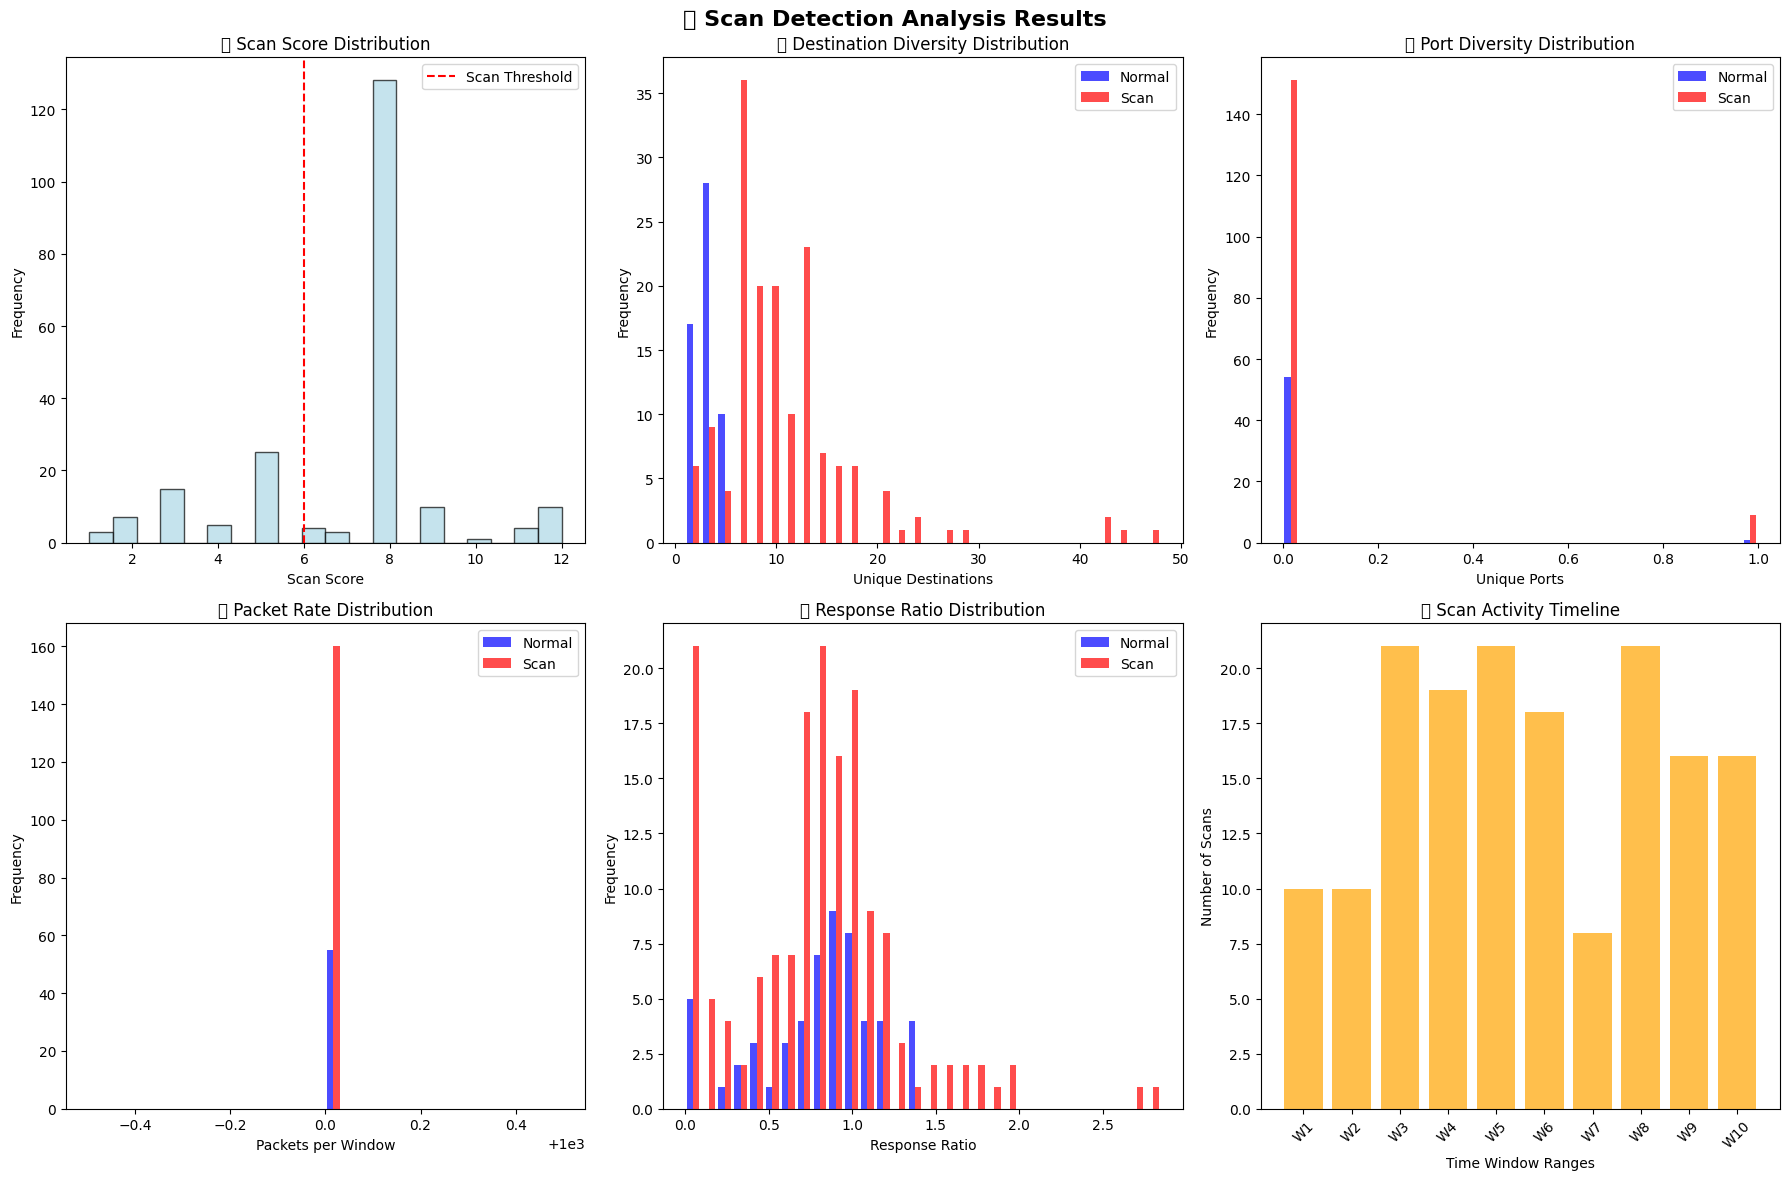

In [10]:


# Cell 8: Visualize Scan Detection Results
def plot_scan_detection_results(features_df, labels, scan_scores):
    """Create visualizations showing scan detection results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🔍 Scan Detection Analysis Results', fontsize=16, fontweight='bold')
    
    # 1. Scan Score Distribution
    axes[0,0].hist(scan_scores, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0,0].axvline(x=6, color='red', linestyle='--', label='Scan Threshold')
    axes[0,0].set_xlabel('Scan Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('📊 Scan Score Distribution')
    axes[0,0].legend()
    
    # 2. Destination Diversity Comparison
    normal_data = features_df[labels==0]['unique_destinations']
    scan_data = features_df[labels==1]['unique_destinations']
    
    if len(normal_data) > 0 and len(scan_data) > 0:
        axes[0,1].hist([normal_data, scan_data], 
                bins=30, alpha=0.7, label=['Normal', 'Scan'], color=['blue', 'red'])
    elif len(scan_data) > 0:
        axes[0,1].hist(scan_data, bins=30, alpha=0.7, label='Scan', color='red')
    elif len(normal_data) > 0:
        axes[0,1].hist(normal_data, bins=30, alpha=0.7, label='Normal', color='blue')
        
    axes[0,1].set_title('🎯 Destination Diversity Distribution')
    axes[0,1].set_xlabel('Unique Destinations')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    
    # 3. Port Diversity Comparison
    normal_ports = features_df[labels==0]['unique_ports']
    scan_ports = features_df[labels==1]['unique_ports']
    
    if len(normal_ports) > 0 and len(scan_ports) > 0:
        axes[0,2].hist([normal_ports, scan_ports], 
                bins=30, alpha=0.7, label=['Normal', 'Scan'], color=['blue', 'red'])
    elif len(scan_ports) > 0:
        axes[0,2].hist(scan_ports, bins=30, alpha=0.7, label='Scan', color='red')
    elif len(normal_ports) > 0:
        axes[0,2].hist(normal_ports, bins=30, alpha=0.7, label='Normal', color='blue')
        
    axes[0,2].set_title('🔌 Port Diversity Distribution')
    axes[0,2].set_xlabel('Unique Ports')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].legend()
    
    # 4. Packet Rate Distribution
    normal_packets = features_df[labels==0]['total_packets']
    scan_packets = features_df[labels==1]['total_packets']
    
    if len(normal_packets) > 0 and len(scan_packets) > 0:
        axes[1,0].hist([normal_packets, scan_packets], 
                bins=30, alpha=0.7, label=['Normal', 'Scan'], color=['blue', 'red'])
    elif len(scan_packets) > 0:
        axes[1,0].hist(scan_packets, bins=30, alpha=0.7, label='Scan', color='red')
    elif len(normal_packets) > 0:
        axes[1,0].hist(normal_packets, bins=30, alpha=0.7, label='Normal', color='blue')
        
    axes[1,0].set_title('📦 Packet Rate Distribution')
    axes[1,0].set_xlabel('Packets per Window')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # 5. Response Ratio Distribution
    normal_response = features_df[labels==0]['response_ratio']
    scan_response = features_df[labels==1]['response_ratio']
    
    if len(normal_response) > 0 and len(scan_response) > 0:
        axes[1,1].hist([normal_response, scan_response], 
                bins=30, alpha=0.7, label=['Normal', 'Scan'], color=['blue', 'red'])
    elif len(scan_response) > 0:
        axes[1,1].hist(scan_response, bins=30, alpha=0.7, label='Scan', color='red')
    elif len(normal_response) > 0:
        axes[1,1].hist(normal_response, bins=30, alpha=0.7, label='Normal', color='blue')
        
    axes[1,1].set_title('📈 Response Ratio Distribution')
    axes[1,1].set_xlabel('Response Ratio')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
    
    # 6. Scan Activity Timeline
    scan_timeline = features_df.copy()
    scan_timeline['is_scan'] = labels
    
    # Group by window ranges for timeline
    window_ranges = pd.cut(scan_timeline['window_id'], bins=min(10, len(scan_timeline)))
    window_scans = scan_timeline.groupby(window_ranges)['is_scan'].sum()
    
    x_pos = range(len(window_scans))
    axes[1,2].bar(x_pos, window_scans.values, color='orange', alpha=0.7)
    axes[1,2].set_title('⏰ Scan Activity Timeline')
    axes[1,2].set_xlabel('Time Window Ranges')
    axes[1,2].set_ylabel('Number of Scans')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels([f'W{i+1}' for i in x_pos], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create the scan detection visualizations
plot_scan_detection_results(features_df, labels, scan_scores)




# Machine Learning Model Training


In [11]:


# Cell 9: Train Machine Learning Models
def train_models(features_df, labels):
    """Train ML models for scan detection"""
    print("🤖 Training machine learning models...")
    
    # Select features for training (exclude metadata columns)
    feature_cols = [col for col in features_df.columns 
                   if col not in ['window_id', 'packet_position']]
    X = features_df[feature_cols]
    y = labels
    
    print(f"📊 Features used for training: {len(feature_cols)}")
    print(f"📈 Training samples: {len(X)}")
    print(f"🎯 Positive samples (scans): {y.sum()}")
    print(f"✅ Negative samples (normal): {len(y) - y.sum()}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Initialize scalers and models
    scaler = StandardScaler()
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    svm_model = SVC(kernel='rbf', random_state=42, probability=True)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    print("\n🌲 Training Random Forest...")
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Train SVM
    print("🎯 Training SVM...")
    svm_model.fit(X_train_scaled, y_train)
    svm_pred = svm_model.predict(X_test_scaled)
    svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate models
    print("\n" + "="*50)
    print("🌲 RANDOM FOREST RESULTS")
    print("="*50)
    print(classification_report(y_test, rf_pred, target_names=['Normal', 'Scan']))
    
    print("\n" + "="*50)
    print("🎯 SVM RESULTS")
    print("="*50)
    print(classification_report(y_test, svm_pred, target_names=['Normal', 'Scan']))
    
    return {
        'X_test': X_test,
        'y_test': y_test,
        'rf_pred': rf_pred,
        'svm_pred': svm_pred,
        'rf_proba': rf_proba,
        'svm_proba': svm_proba,
        'feature_names': feature_cols,
        'scaler': scaler,
        'rf_model': rf_model,
        'svm_model': svm_model
    }

# Train models only if we have enough data
if len(features_df) > 10 and labels.sum() > 0:
    results = train_models(features_df, labels)
else:
    print("⚠️ Not enough data or no scans detected for model training.")
    print(f"   Windows: {len(features_df)}, Scans: {labels.sum()}")
    results = None

    

🤖 Training machine learning models...
📊 Features used for training: 23
📈 Training samples: 215
🎯 Positive samples (scans): 160
✅ Negative samples (normal): 55

🌲 Training Random Forest...
🎯 Training SVM...

🌲 RANDOM FOREST RESULTS
              precision    recall  f1-score   support

      Normal       0.80      0.94      0.86        17
        Scan       0.98      0.92      0.95        48

    accuracy                           0.92        65
   macro avg       0.89      0.93      0.91        65
weighted avg       0.93      0.92      0.92        65


🎯 SVM RESULTS
              precision    recall  f1-score   support

      Normal       0.79      0.65      0.71        17
        Scan       0.88      0.94      0.91        48

    accuracy                           0.86        65
   macro avg       0.83      0.79      0.81        65
weighted avg       0.86      0.86      0.86        65




# Model Performance Visualization


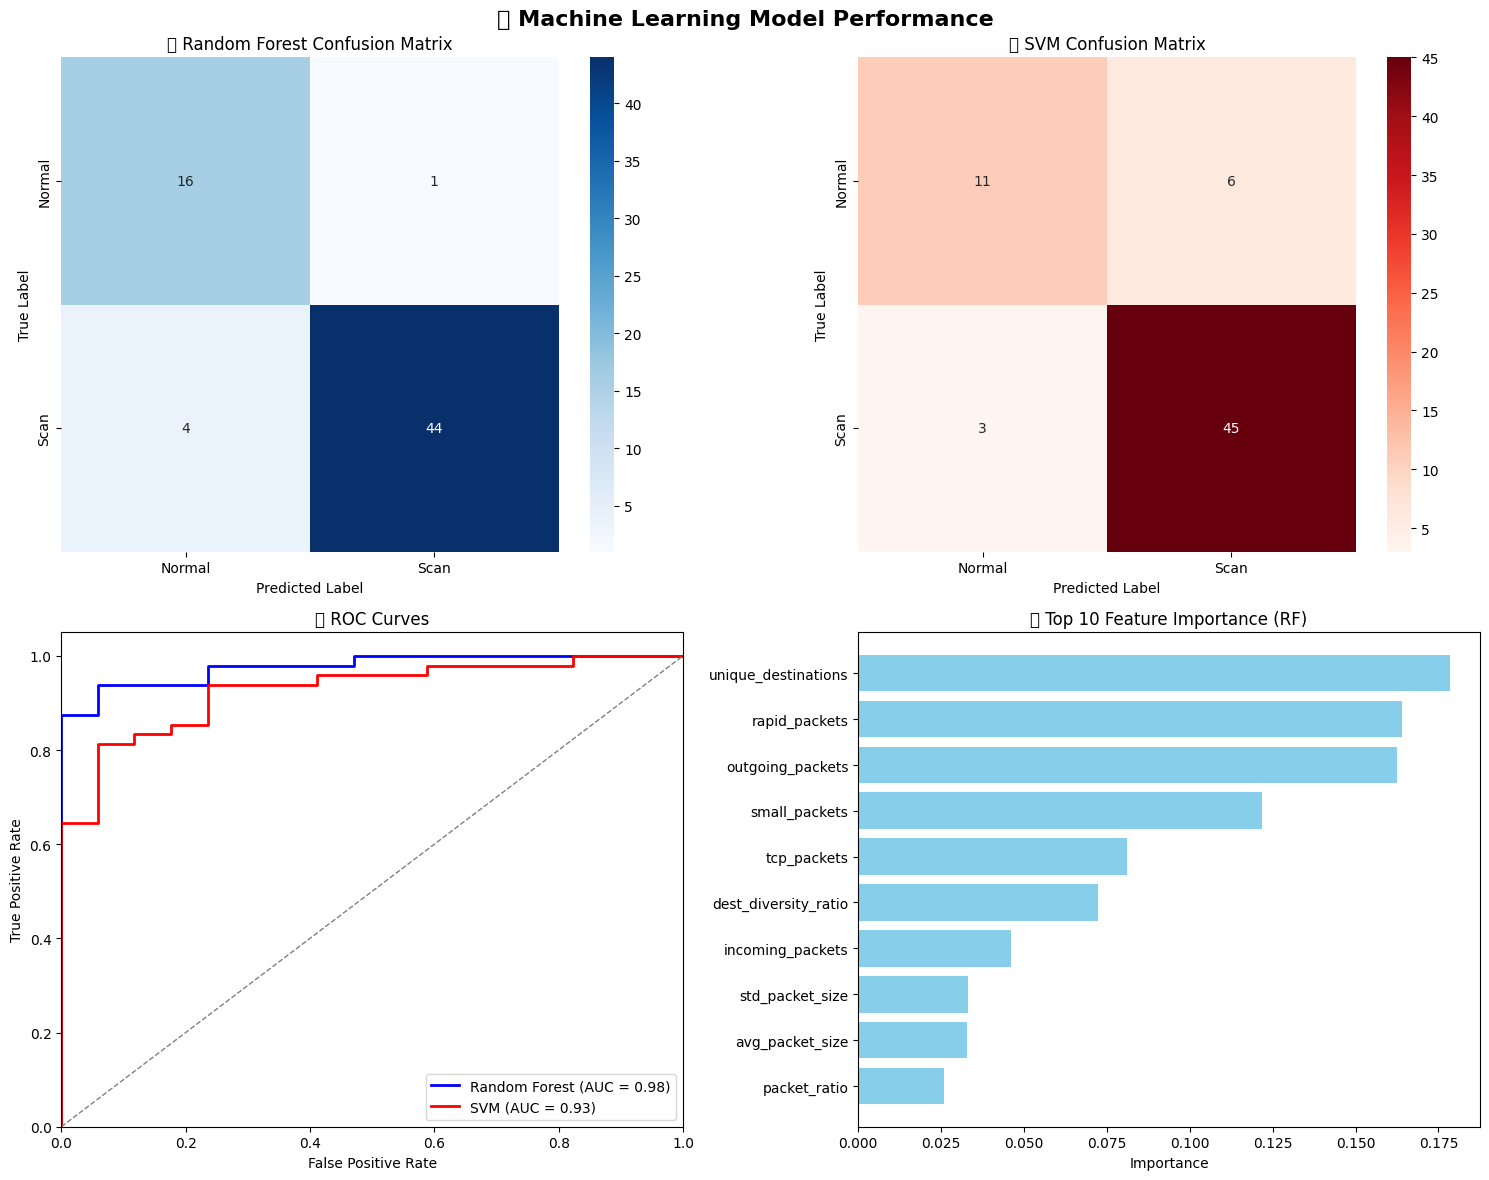


🏆 TOP 10 MOST IMPORTANT FEATURES:
 1. packet_ratio              : 0.0259
 2. avg_packet_size           : 0.0329
 3. std_packet_size           : 0.0332
 4. incoming_packets          : 0.0460
 5. dest_diversity_ratio      : 0.0722
 6. tcp_packets               : 0.0811
 7. small_packets             : 0.1219
 8. outgoing_packets          : 0.1625
 9. rapid_packets             : 0.1641
10. unique_destinations       : 0.1786


In [12]:


# Cell 10: Visualize Model Performance
def plot_model_performance(results):
    """Create visualizations of model performance"""
    if results is None:
        print("⚠️ No model results to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🤖 Machine Learning Model Performance', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix - Random Forest
    from sklearn.metrics import confusion_matrix
    cm_rf = confusion_matrix(results['y_test'], results['rf_pred'])
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Normal', 'Scan'], yticklabels=['Normal', 'Scan'])
    axes[0,0].set_title('🌲 Random Forest Confusion Matrix')
    axes[0,0].set_ylabel('True Label')
    axes[0,0].set_xlabel('Predicted Label')
    
    # 2. Confusion Matrix - SVM
    cm_svm = confusion_matrix(results['y_test'], results['svm_pred'])
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=axes[0,1],
                xticklabels=['Normal', 'Scan'], yticklabels=['Normal', 'Scan'])
    axes[0,1].set_title('🎯 SVM Confusion Matrix')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')
    
    # 3. ROC Curves
    from sklearn.metrics import roc_curve, auc
    
    # ROC for Random Forest
    fpr_rf, tpr_rf, _ = roc_curve(results['y_test'], results['rf_proba'])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    # ROC for SVM
    fpr_svm, tpr_svm, _ = roc_curve(results['y_test'], results['svm_proba'])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    
    axes[1,0].plot(fpr_rf, tpr_rf, color='blue', lw=2, 
                   label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    axes[1,0].plot(fpr_svm, tpr_svm, color='red', lw=2,
                   label=f'SVM (AUC = {roc_auc_svm:.2f})')
    axes[1,0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('📈 ROC Curves')
    axes[1,0].legend(loc="lower right")
    
    # 4. Feature Importance (Random Forest)
    importance = results['rf_model'].feature_importances_
    feature_importance = pd.DataFrame({
        'feature': results['feature_names'],
        'importance': importance
    }).sort_values('importance', ascending=True)
    
    # Plot top 10 features
    top_features = feature_importance.tail(10)
    axes[1,1].barh(range(len(top_features)), top_features['importance'], color='skyblue')
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'])
    axes[1,1].set_title('🏆 Top 10 Feature Importance (RF)')
    axes[1,1].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Visualize model performance
if results is not None:
    feature_importance = plot_model_performance(results)
    
    print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
    print("="*50)
    for i, (_, row) in enumerate(feature_importance.tail(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25} : {row['importance']:.4f}")


        


# Detailed Analysis and Summary


In [13]:

def generate_detailed_report(features_df, labels, scan_scores, results=None):
    """Generate a comprehensive analysis report"""
    print("="*60)
    print("📋 COMPREHENSIVE NMAP SCAN DETECTION REPORT")
    print("="*60)
    
    # Dataset Overview
    print("\n📊 DATASET OVERVIEW")
    print("-" * 30)
    print(f"Total network windows analyzed: {len(features_df):,}")
    print(f"Total packets processed: {features_df['total_packets'].sum():,}")
    print(f"Average packets per window: {features_df['total_packets'].mean():.1f}")
    
    # Scan Detection Summary
    print(f"\n🚨 SCAN DETECTION SUMMARY")
    print("-" * 30)
    print(f"Windows flagged as scans: {labels.sum():,}")
    print(f"Windows flagged as normal: {(len(labels) - labels.sum()):,}")
    print(f"Scan detection rate: {(labels.sum()/len(labels)*100):.2f}%")
    print(f"Average scan score: {scan_scores.mean():.2f}")
    print(f"Max scan score: {scan_scores.max()}")
    
    # Scanning Behavior Analysis
    if labels.sum() > 0:
        scan_windows = features_df[labels == 1]
        normal_windows = features_df[labels == 0]
        
        print(f"\n🔍 SCANNING BEHAVIOR ANALYSIS")
        print("-" * 30)
        print(f"Average destinations per scan: {scan_windows['unique_destinations'].mean():.1f}")
        print(f"Average ports per scan: {scan_windows['unique_ports'].mean():.1f}")
        print(f"Average packets per scan window: {scan_windows['total_packets'].mean():.1f}")
        print(f"Average response ratio in scans: {scan_windows['response_ratio'].mean():.3f}")
        
        print(f"\n📈 COMPARISON: SCAN vs NORMAL TRAFFIC")
        print("-" * 30)
        print(f"{'Metric':<25} {'Normal':<15} {'Scan':<15} {'Ratio':<10}")
        print("-" * 65)
        
        metrics = [
            ('Unique Destinations', 'unique_destinations'),
            ('Unique Ports', 'unique_ports'),
            ('Total Packets', 'total_packets'),
            ('Response Ratio', 'response_ratio'),
            ('Protocol Diversity', 'protocol_diversity')
        ]
        
        for metric_name, metric_col in metrics:
            normal_avg = normal_windows[metric_col].mean() if len(normal_windows) > 0 else 0
            scan_avg = scan_windows[metric_col].mean()
            ratio = scan_avg / normal_avg if normal_avg > 0 else float('inf')
            print(f"{metric_name:<25} {normal_avg:<15.2f} {scan_avg:<15.2f} {ratio:<10.2f}")
    
    # Model Performance (if available)
    if results is not None:
        print(f"\n🤖 MACHINE LEARNING MODEL PERFORMANCE")
        print("-" * 30)
        
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        # Random Forest metrics
        rf_accuracy = accuracy_score(results['y_test'], results['rf_pred'])
        rf_precision = precision_score(results['y_test'], results['rf_pred'])
        rf_recall = recall_score(results['y_test'], results['rf_pred'])
        rf_f1 = f1_score(results['y_test'], results['rf_pred'])
        
        # SVM metrics
        svm_accuracy = accuracy_score(results['y_test'], results['svm_pred'])
        svm_precision = precision_score(results['y_test'], results['svm_pred'])
        svm_recall = recall_score(results['y_test'], results['svm_pred'])
        svm_f1 = f1_score(results['y_test'], results['svm_pred'])
        
        print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
        print("-" * 55)
        print(f"{'Random Forest':<15} {rf_accuracy:<10.3f} {rf_precision:<10.3f} {rf_recall:<10.3f} {rf_f1:<10.3f}")
        print(f"{'SVM':<15} {svm_accuracy:<10.3f} {svm_precision:<10.3f} {svm_recall:<10.3f} {svm_f1:<10.3f}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    print("-" * 30)
    if labels.sum() > 0:
        print("⚠️  Scanning activity detected in your network traffic!")
        print("🔒 Consider implementing the following security measures:")
        print("   • Monitor traffic to frequently scanned destinations")
        print("   • Implement rate limiting for outbound connections")
        print("   • Set up alerts for high destination diversity")
        print("   • Review firewall rules and access controls")
        print("   • Consider implementing intrusion detection systems")
    else:
        print("✅ No significant scanning activity detected.")
        print("🛡️  Your network traffic appears normal, but continue monitoring:")
        print("   • Regular traffic analysis")
        print("   • Monitor for unusual patterns")
        print("   • Keep security tools updated")
    
    print(f"\n" + "="*60)
    print("📊 ANALYSIS COMPLETE")
    print("="*60)

# Generate the comprehensive report
generate_detailed_report(features_df, labels, scan_scores, results)



📋 COMPREHENSIVE NMAP SCAN DETECTION REPORT

📊 DATASET OVERVIEW
------------------------------
Total network windows analyzed: 215
Total packets processed: 215,000
Average packets per window: 1000.0

🚨 SCAN DETECTION SUMMARY
------------------------------
Windows flagged as scans: 160
Windows flagged as normal: 55
Scan detection rate: 74.42%
Average scan score: 7.16
Max scan score: 12

🔍 SCANNING BEHAVIOR ANALYSIS
------------------------------
Average destinations per scan: 10.8
Average ports per scan: 0.1
Average packets per scan window: 1000.0
Average response ratio in scans: 0.782

📈 COMPARISON: SCAN vs NORMAL TRAFFIC
------------------------------
Metric                    Normal          Scan            Ratio     
-----------------------------------------------------------------
Unique Destinations       3.18            10.79           3.39      
Unique Ports              0.02            0.06            3.09      
Total Packets             1000.00         1000.00         1.00     


# Export Results and Cleanup


In [14]:


# Cell 12: Export Results and Cleanup
def export_results(features_df, labels, scan_scores, results=None):
    """Export analysis results to files"""
    print("💾 Exporting analysis results...")
    
    # Create results dataframe
    results_df = features_df.copy()
    results_df['is_scan'] = labels
    results_df['scan_score'] = scan_scores
    
    # Add model predictions if available
    if results is not None:
        # Create full predictions for all data
        feature_cols = results['feature_names']
        X_full = features_df[feature_cols]
        
        rf_pred_full = results['rf_model'].predict(X_full)
        rf_proba_full = results['rf_model'].predict_proba(X_full)[:, 1]
        
        X_full_scaled = results['scaler'].transform(X_full)
        svm_pred_full = results['svm_model'].predict(X_full_scaled)
        svm_proba_full = results['svm_model'].predict_proba(X_full_scaled)[:, 1]
        
        results_df['rf_prediction'] = rf_pred_full
        results_df['rf_probability'] = rf_proba_full
        results_df['svm_prediction'] = svm_pred_full
        results_df['svm_probability'] = svm_proba_full
    
    # Export to CSV
    output_filename = f'scan_detection_results_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"✅ Results exported to: {output_filename}")
    
    # Export scan windows only
    if labels.sum() > 0:
        scan_windows = results_df[results_df['is_scan'] == 1]
        scan_filename = f'detected_scans_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv'
        scan_windows.to_csv(scan_filename, index=False)
        print(f"🚨 Scan windows exported to: {scan_filename}")
    
    # Create summary statistics
    summary_stats = {
        'total_windows': len(features_df),
        'scan_windows': int(labels.sum()),
        'normal_windows': int(len(labels) - labels.sum()),
        'scan_percentage': float(labels.sum() / len(labels) * 100),
        'avg_scan_score': float(scan_scores.mean()),
        'max_scan_score': int(scan_scores.max())
    }
    
    if labels.sum() > 0:
        scan_features = features_df[labels == 1]
        summary_stats.update({
            'avg_destinations_per_scan': float(scan_features['unique_destinations'].mean()),
            'avg_ports_per_scan': float(scan_features['unique_ports'].mean()),
            'avg_packets_per_scan': float(scan_features['total_packets'].mean())
        })
    
    # Export summary
    import json
    summary_filename = f'analysis_summary_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.json'
    with open(summary_filename, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    print(f"📋 Summary statistics exported to: {summary_filename}")
    
    return results_df, summary_stats

# Export results
final_results, summary = export_results(features_df, labels, scan_scores, results)

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"📁 Files generated:")
print(f"   • Detailed results CSV")
if labels.sum() > 0:
    print(f"   • Detected scans CSV")
print(f"   • Summary statistics JSON")

print(f"\n📊 Quick Summary:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"   {key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"   {key.replace('_', ' ').title()}: {value}")

        

💾 Exporting analysis results...
✅ Results exported to: scan_detection_results_20250629_184113.csv
🚨 Scan windows exported to: detected_scans_20250629_184113.csv
📋 Summary statistics exported to: analysis_summary_20250629_184113.json

🎉 ANALYSIS COMPLETE!
📁 Files generated:
   • Detailed results CSV
   • Detected scans CSV
   • Summary statistics JSON

📊 Quick Summary:
   Total Windows: 215
   Scan Windows: 160
   Normal Windows: 55
   Scan Percentage: 74.42
   Avg Scan Score: 7.16
   Max Scan Score: 12
   Avg Destinations Per Scan: 10.79
   Avg Ports Per Scan: 0.06
   Avg Packets Per Scan: 1000.00



# Interactive Analysis


In [15]:


# Cell 13: Interactive Analysis Functions (Optional)
def interactive_analysis(features_df, labels):
    """Provide interactive analysis capabilities"""
    print("🔧 Interactive Analysis Tools")
    print("="*40)
    
    def analyze_window(window_id):
        """Analyze a specific window in detail"""
        if window_id >= len(features_df):
            print(f"❌ Window {window_id} not found. Max window ID: {len(features_df)-1}")
            return
        
        window = features_df.iloc[window_id]
        is_scan = labels[window_id]
        
        print(f"\n🔍 WINDOW {window_id} ANALYSIS")
        print("-" * 30)
        print(f"Classification: {'🚨 SCAN' if is_scan else '✅ NORMAL'}")
        print(f"Unique Destinations: {window['unique_destinations']}")
        print(f"Unique Ports: {window['unique_ports']}")
        print(f"Total Packets: {window['total_packets']}")
        print(f"Response Ratio: {window['response_ratio']:.3f}")
        print(f"Protocol Diversity: {window['protocol_diversity']}")
        print(f"Sequential Ports: {window['sequential_ports']}")
        
    def top_scan_windows(n=5):
        """Show top N scan windows"""
        if labels.sum() == 0:
            print("❌ No scan windows detected")
            return
        
        scan_windows = features_df[labels == 1].copy()
        scan_windows['window_id'] = scan_windows.index
        scan_windows = scan_windows.sort_values('unique_destinations', ascending=False)
        
        print(f"\n🏆 TOP {n} SCAN WINDOWS (by destination diversity)")
        print("-" * 60)
        
        for i, (_, window) in enumerate(scan_windows.head(n).iterrows(), 1):
            print(f"{i}. Window {window['window_id']}: "
                  f"{window['unique_destinations']} destinations, "
                  f"{window['unique_ports']} ports, "
                  f"{window['total_packets']} packets")
    
    def search_by_destinations(min_destinations=5):
        """Find windows with high destination diversity"""
        high_dest_windows = features_df[features_df['unique_destinations'] >= min_destinations]
        
        print(f"\n🎯 WINDOWS WITH {min_destinations}+ DESTINATIONS")
        print("-" * 40)
        
        for idx, window in high_dest_windows.iterrows():
            is_scan = labels[idx]
            print(f"Window {idx}: {window['unique_destinations']} destinations "
                  f"({'SCAN' if is_scan else 'NORMAL'})")
    
    # Make functions available
    globals()['analyze_window'] = analyze_window
    globals()['top_scan_windows'] = top_scan_windows
    globals()['search_by_destinations'] = search_by_destinations
    
    print("\n🛠️ Available functions:")
    print("   • analyze_window(window_id) - Analyze specific window")
    print("   • top_scan_windows(n=5) - Show top scan windows")
    print("   • search_by_destinations(min=5) - Find high-diversity windows")
    print("\nExample usage:")
    print("   analyze_window(0)")
    print("   top_scan_windows(10)")
    print("   search_by_destinations(8)")

# Initialize interactive analysis
interactive_analysis(features_df, labels)

# Show some examples automatically
if labels.sum() > 0:
    print("\n" + "="*50)
    top_scan_windows(3)
    
    print("\n" + "="*50)
    search_by_destinations(5)

    

🔧 Interactive Analysis Tools

🛠️ Available functions:
   • analyze_window(window_id) - Analyze specific window
   • top_scan_windows(n=5) - Show top scan windows
   • search_by_destinations(min=5) - Find high-diversity windows

Example usage:
   analyze_window(0)
   top_scan_windows(10)
   search_by_destinations(8)


🏆 TOP 3 SCAN WINDOWS (by destination diversity)
------------------------------------------------------------
1. Window 198.0: 48.0 destinations, 0.0 ports, 1000.0 packets
2. Window 166.0: 44.0 destinations, 0.0 ports, 1000.0 packets
3. Window 193.0: 42.0 destinations, 0.0 ports, 1000.0 packets


🎯 WINDOWS WITH 5+ DESTINATIONS
----------------------------------------
Window 0: 8.0 destinations (SCAN)
Window 2: 6.0 destinations (SCAN)
Window 3: 12.0 destinations (SCAN)
Window 4: 10.0 destinations (SCAN)
Window 5: 17.0 destinations (SCAN)
Window 6: 7.0 destinations (SCAN)
Window 7: 5.0 destinations (NORMAL)
Window 10: 8.0 destinations (SCAN)
Window 11: 7.0 destinations (SCAN)